## Supervisor: Research Agent

### Supervisor-Agent System:

- Structure: Supervisor >> [Delegates Sub-Topics] >> Research Sub-Agents >> [Research & Findings] >> Supervisor >> Output

- A single research agent can perform deep research and multi-agent systems are computationally more expensive

- The reason to employ a Supervisor in a Multi-Agent System:
    - 1. Context Isolation: Supervisor can delegate tasks and sub-agents can work on separate sections of research
        - This leads to clear cut tasks that need to be performed and no context confusion for the sub-agent
    - 2. Context Clash: Single agent working on a task leads to context window accumulation across different sub-topics
        - The single agent could hallucinate and not consider vital information due to a long and opposing context ideas

- Hence, having context isolation and no context clash between sub-agents would lead to better research analysis 

### Supervisor Agent Prompt

- I'll follow a similar prompt structure to that of the research agent + Delegating tasks and Assessing Findings

- Designing the prompt for Supervisor Agent:
    - 1. Think like an Agent:
        - Read Question: Understand the user's question and check if all relevant information is present
        - Delegate Research: Consider the question and delegate research (could involve mulitple research sub-topics)
        - Pause & Assess: After receiving findings check if all information is present/ any more research required
    
    - 2. Hard Limits:
        - Single Agent Bias: Task is simple >> single agent unless parallelization of multiple topics required
        - Stop Research: Stop when information is present, do not delegate for additional tasks if confident
        - Tool Calls: Limit tool calls to 3 if unable to Conduct Research and find the right sources 

    - 3. Display Thinking
        - Before the Conduct Reseach tool use the think tool to analyze and plan the system
        - After Conducting Research assess for vital information present, missing information, sufficient information

    - 4. Scaling Rules (Sub-Agent Selection):
        - Simple Findings and Facts >> Use Single Agent
        - Comparisons and Complex Tasks >> Use Multiple Sub-Agents (3 Sub-Agents)

- Note:
- It is better to Bias the Supervsior Agent to use a single agent as it would not use multiple agents then for a simple task

In [1]:
from research_utils import show_prompt
from deep_research_prompts.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

In [ ]:
%%writefile state_supervisor_research.py

## This file defines the States and Tools for the Supervisor Agent 

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

In [ ]:
%%writefile supervisor_multi_agent.py

## This file defines the Multi-Agent System for the Supervisor Agent to Conduct Research and Compress Findings

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_prompts.prompts import lead_researcher_prompt
from research_agent import researcher_agent
from state_supervisor_research import (SupervisorState, ConductResearch, ResearchComplete)
from research_stage_prompt.prompts import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

## Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


## Agent Configuration

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(model="ollama:granite3.3:8b")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

## System constants
## Maximum number of tool call iterations for individual researcher agents
## This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

## Maximum number of concurrent research agents the supervisor can launch
## This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

## Supervisor Nodes

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    ## Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    ## Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    ## Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    # Next step involves supervisor to make decisions
    next_step = "supervisor" 
    should_end = False
    
    ## Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    ## Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

## Compile Agent

## Build supervisor workflow
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

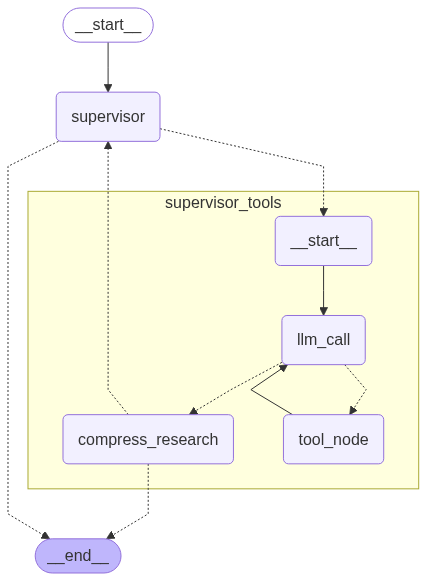

In [2]:
from IPython.display import Image, display
from supervisor_multi_agent import supervisor_agent

# Display Agent Workflow
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Invoke the multi-agent supervisor agent
from research_utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in Toronto that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the Toronto area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in Toronto, emphasizing their coffee quality according to the latest available data as  
of July 2025."""


## Print the Supervisor Messages to check the research process conducted by the Agent
result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in Toronto that are considered the best based specifically     │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the Toronto area,    │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in Toronto, emphasizing their coffee quality according to the latest available data as     │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To effectively address this research question, I'll break it down into manageable parts and delegate research   │
│ tasks where appropriate. Here's my plan:                                                                        │
│                                                                                                                 │
│ 1. **Identify Coffee Shops in Toronto**: Conduct a broad search to compile a comprehensive list of coffee shops │
│ currently operating within Toronto. This task can be accomplished using a single sub-agent. I'll look for       │
│ up-to-date directories, local business lists, or even reach out to local coffee associations if necessary.      │
│                                                                                                                 │
│ 2. **Evaluate Coffee Quality**: Since the primary criterion is coffee quality, utilize multiple sources to      │
│ assess each shop:                                                                                               │
│    - **Expert Reviews**: Engage sub-agents to research and compile reviews from reputable organizations like    │
│ Coffee Review and the Specialty Coffee Association. This will provide authoritative assessments based on        │
│ professional tasting standards.                                                                                 │
│                                                                                                                 │
│    - **Customer Ratings and Feedback**: Sub-agents can search review aggregators such as Google, Yelp, and      │
│ Foodora for customer feedback specifically mentioning coffee quality. These platforms offer direct consumer     │
│ insights into the shops' strengths and weaknesses regarding their primary product.                              │
│                                                                                                                 │
│ 3. **Synthesize Findings**: Compile data gathered from each sub-agent into a comparative analysis focusing on   │
│ coffee quality. I will prioritize recent reviews and ratings to ensure relevance as of July 2025.               │
│                                                                                                                 │
│ 4. **Rank and Report**: Using the synthesized data, create a ranked list highlighting the top coffee shops in   │
│ Toronto based on their coffee quality, supported by evidence from primary sources.                              │
│                                                                                                                 │
│ Now I will call ConductResearch with these tasks.                                                               │
│                                                                                                                 │
│ ```python                                                                                                       │
│ # Call ConductResearch to execute the research plan                                                             │
│                                                                                                                 │
│ ConductResearch(research_topic="Identify and list all operational coffee shops in Toronto (as of July 2025)")   │
│ ConductResearch(research_topic="Gather expert reviews on coffee quality from Coffee Review and Specialty Coffee │
│ Association for each shop")                                                                                     │
│ ConductResearch(research_topic="Collect customer ratings and feedback focusing on coffee quality from Google,   │
│ Yelp, and Foodora reviews (as recent as possible, up to July 2025)")                                            │
│ ```                                                    

### Multi-Agent Evalution Example 

In [8]:
## Example messages with think_tool calls and tool messages for evaluation
## Giving Examples for whether parallelization is required or not
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Eglinton, Toronto"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Eglinton, Toronto)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Eglinton, Toronto).", tool_call_id="call_think_2", name="think_tool")
]

In [9]:
## Define LangChain Client and Dataset
import os
from dotenv import load_dotenv
from langsmith import Client

## Initialize client 
load_dotenv("api_connect.env")
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

## Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

In [10]:
## Evaluate using LangChain
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

async def evaluate_client():
    await langsmith_client.aevaluate(
        target_func,
        data=dataset_name,
        evaluators=[evaluate_parallelism],
        experiment_prefix="Supervisor Parallelism",
    )

await evaluate_client()

View the evaluation results for experiment: 'Supervisor Parallelism-f6d1d199' at:
https://smith.langchain.com/o/7f9b00dd-1fb4-43be-b697-24cb112bddff/datasets/a382966b-cfbf-4c71-90e5-7099f118aab5/compare?selectedSessions=5c1c85d4-f584-47e6-aaac-9f892f1bad8c




c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2it [02:49, 84.61s/it]
